# 2016 US Bike Share Activity Snapshot

## Table of Contents
- [Introduction](#intro)
- [Posing Questions](#pose_questions)
- [Data Collection and Wrangling](#wrangling)
  - [Condensing the Trip Data](#condensing)
- [Exploratory Data Analysis](#eda)
  - [Statistics](#statistics)
  - [Visualizations](#visualizations)
- [Performing Your Own Analysis](#eda_continued)
- [Conclusions](#conclusions)

<a id='intro'></a>
## Introduction

Over the past decade, bicycle-sharing systems have been growing in number and popularity in cities across the world. Bicycle-sharing systems allow users to rent bicycles for short trips, typically 30 minutes or less. Thanks to the rise in information technologies, it is easy for a user of the system to access a dock within the system to unlock or return bicycles. These technologies also provide a wealth of data that can be used to explore how these bike-sharing systems are used.

In this project, I will perform an exploratory analysis on data provided by [Motivate](https://www.motivateco.com/), a bike-share system provider for many major cities in the United States. I will compare the system usage between three large cities: New York City, Chicago, and Washington, DC. We will also see if there are any differences within each system for those users that are registered, regular users and those users that are short-term, casual users.

<a id='pose_questions'></a>
## Posing Questions

Before looking at the bike sharing data, we will start by asking questions the company Motivate executives might want to understand about theie bike share data. Consider, for example, what kinds of information would you want to know about in order to make smarter business decisions? I asked myself, if I were a user of the bike-share service, what factors might influence how I would want to use the service?

Here are least two questions related to bike sharing that I will attempt to answer by using this data.

**Answer**: 
- 1) Which type of user provides more revenue in terms of services used (reg or casual)?
- 2) Which city is generating the most revenue to allow Motivate to know where to concentrate expansion resources?
- 3) When is the least busiest time to rent a bike?
- 4) Do we have more casual users and if so, should we offer discounts to become regs?


<a id='wrangling'></a>
## Data Collection and Wrangling

Now it's time to collect and explore our data. In this project, we will focus on the record of individual trips taken in 2016 from our selected cities: New York City, Chicago, and Washington, DC. Each of these cities has a page where we can freely download the trip data.:

- New York City (Citi Bike): [Link](https://www.citibikenyc.com/system-data)
- Chicago (Divvy): [Link](https://www.divvybikes.com/system-data)
- Washington, DC (Capital Bikeshare): [Link](https://www.capitalbikeshare.com/system-data)

If you visit these pages, you will notice that each city has a different way of delivering its data. Chicago updates with new data twice a year, Washington DC is quarterly, and New York City is monthly. **Note, you do not need to download the data yourself.** The data has already been collected and stored in the `/data/` folder of the project files. While the original data for 2016 is spread among multiple files for each city, the files in the `/data/` folder collect all of the trip data for the year into one file per city. Some data wrangling of inconsistencies in timestamp format within each city has already been performed for you. In addition, a random 2% sample of the original data is taken to make the exploration more manageable. 

Since there is a lot of data for us to investigate, we will start off by looking at one entry from each of the cities we're going to analyze. Running the first code cell below will load some packages and functions that we'll be using in my analysis going forward. The second code cell will print out the first trip recorded from each of the cities (the second line of each data file).


In [1]:
## import all necessary packages and functions.
import csv # read and write csv files
from datetime import datetime # operations to parse dates
from pprint import pprint
from pprint import pformat


In [2]:
# use to print data structures like dictionaries in a nicer way than the base print function.
def print_first_point(filename):
    """
    This function prints and returns the first data point (second row) from
    a csv file that includes a header row.
    """
    # print city name for reference
    city = filename.split('-')[0].split('/')[-1]
    print('\nCity: {}'.format(city))
    
    with open(filename, 'r') as f_in:
        ## Used the csv library to set up a DictReader object. ##
        ## see https://docs.python.org/3/library/csv.html      ##

        trip_reader = csv.DictReader(f_in)
        
        ## Used a function on the DictReader object to read the          ##
        ## first trip from the data file and store it in a variable.     ##
        ## see https://docs.python.org/3/library/csv.html#reader-objects ##

        first_trip = next(trip_reader)
   
        ## Used the pprint library to print the first trip.    ##
        ## see https://docs.python.org/3/library/pprint.html   ##
      
        pprint(first_trip)


    # output city name and first trip for later testing
    return (city, first_trip)

# list of files for each city
data_files = ['./data/NYC-CitiBike-2016.csv',
              './data/Chicago-Divvy-2016.csv',
              './data/Washington-CapitalBikeshare-2016.csv',]

# print the first trip from each file, store in dictionary
example_trips = {}
for data_file in data_files:
    city, first_trip = print_first_point(data_file)
    example_trips[city] = first_trip


City: NYC


FileNotFoundError: [Errno 2] No such file or directory: './data/NYC-CitiBike-2016.csv'

If everything has been filled out correctly, you should see below the printout of each city name (which has been parsed from the data file name) that the first trip has been parsed in the form of a dictionary. When you set up a `DictReader` object, the first row of the data file is normally interpreted as column names. Every other row in the data file will use those column names as keys, as a dictionary is generated for each row.

This will be useful since we can refer to quantities by an easily-understandable label instead of just a numeric index. For example, if we have a trip stored in the variable `row`, then we would rather get the trip duration from `row['duration']` instead of `row[0]`.

<a id='condensing'></a>
### Condensing the Trip Data

It should also be observable from the above printout that each city provides different information. Even where the information is the same, the column names and formats are sometimes different. To make things as simple as possible when we get to the actual exploration, we should trim and clean the data. Cleaning the data makes sure that the data formats across the cities are consistent, while trimming focuses only on the parts of the data we are most interested in to make the exploration easier to work with.

We will generate new data files with five values of interest for each trip: trip duration, starting month, starting hour, day of the week, and user type. Each of these may require additional wrangling depending on the city:

- **Duration**: This has been given to us in seconds (New York, Chicago) or milliseconds (Washington). A more natural unit of analysis will be if all the trip durations are given in terms of minutes.
- **Month**, **Hour**, **Day of Week**: Ridership volume is likely to change based on the season, time of day, and whether it is a weekday or weekend. Use the start time of the trip to obtain these values. The New York City data includes the seconds in their timestamps, while Washington and Chicago do not. The [`datetime`](https://docs.python.org/3/library/datetime.html) package will be very useful here to make the needed conversions.
- **User Type**: It is possible that users who are subscribed to a bike-share system will have different patterns of use compared to users who only have temporary passes. Washington divides its users into two types: 'Registered' for users with annual, monthly, and other longer-term subscriptions, and 'Casual', for users with 24-hour, 3-day, and other short-term passes. The New York and Chicago data uses 'Subscriber' and 'Customer' for these groups, respectively. For consistency, you will convert the Washington labels to match the other two. It also turns out that there are some trips in the New York city dataset that do not have an attached user type. Since we don't have enough information to fill these values in, just leave them as-is for now.


**Question 3a**: Complete the helper functions in the code cells below to address each of the cleaning tasks described above.

In [3]:
def duration_in_mins(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the trip duration in units of minutes.
    
    Remember that Washington is in terms of milliseconds while Chicago and NYC
    are in terms of seconds. 
    
    HINT: The csv module reads in all of the data as strings, including numeric
    values. You will need a function to convert the strings into an appropriate
    numeric type when making your transformations.
    see https://docs.python.org/3/library/functions.html
    """

    if city == 'Washington':        
        input_duration = datum['Duration (ms)']
        return (int(input_duration)/1000)/60

    else:
        input_duration = datum['tripduration']
        return (int(input_duration))/60
   
    return duration


# Some tests to check that my code works. There should be no output if all of
# the assertions pass. The `example_trips` dictionary was obtained from when
# you printed the first trip from each of the original data files.
tests = {'NYC': 13.9833,
         'Chicago': 15.4333,
         'Washington': 7.1231}



for city in tests:
    assert abs(duration_in_mins(example_trips[city], city) - tests[city]) < .001

#    if abs(duration_in_mins(example_trips[city], city) - tests[city]) < .001:
#        print("Yes, the time for {} is good!".format(city))
    
#print(duration_in_mins(example_trips['NYC'], 'NYC'))
#print(duration_in_mins(example_trips['Chicago'], 'Chicago'))
#print(duration_in_mins(example_trips['Washington'], 'Washington'))


# Since there is no assert error given this block of code is running as expected for now.


In [4]:
def time_of_trip(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the month, hour, and day of the week in
    which the trip was made.
    
    Remember that NYC includes seconds, while Washington and Chicago do not.
    
    HINT: You should use the datetime module to parse the original date
    strings into a format that is useful for extracting the desired information.
    see https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior
    """

    #Get the MONTH, HOUR, and Day of the week
    
    if city == 'NYC':
        # For NYC date form is eg.'starttime': '1/1/2016 00:09:55'
        raw_date = datetime.strptime(datum['starttime'], '%m/%d/%Y %H:%M:%S')
        
    elif city == 'Chicago':
        # For Chicago date form is eg.'starttime': '3/31/2016 23:30'
        raw_date = datetime.strptime(datum['starttime'], '%m/%d/%Y %H:%M')
        
    else: #This means city is Washington
        # For Washington date form is eg. 'Start date': '3/31/2016 22:57',
        raw_date = datetime.strptime(datum['Start date'], '%m/%d/%Y %H:%M')
 
    month = raw_date.strftime('%B')
    hour = raw_date.strftime('%I%p')
    day_of_week = raw_date.strftime('%A')
   
    return (month, hour, day_of_week)


# Some tests to check that my code works. There should be no output if all of
# the assertions pass. The `example_trips` dictionary was obtained from when
# you printed the first trip from each of the original data files.

# NOTE: I changed the data format for my code to allow more meaningful data

test1 = {'NYC': (1, 0, 'Friday'),
         'Chicago': (3, 23, 'Thursday'),
         'Washington': (3, 22, 'Thursday')}

#Test2 has more intuitive date outputs. This is reflected in the Assert test below

test2 = {'NYC': ('January', '12AM', 'Friday'),
         'Chicago': ('March', '11PM', 'Thursday'),
         'Washington': ('March', '10PM', 'Thursday')}


#Print tests to confirm I am getting the correct format              
#print(time_of_trip(example_trips['NYC'], 'NYC'))
#print(time_of_trip(example_trips['Chicago'], 'Chicago'))
#print(time_of_trip(example_trips['Washington'], 'Washington'))


                 
for city in test2:
    assert time_of_trip(example_trips[city], city) == test2[city]

# Since there is no assert error given this block of code is running as expected for now.


In [4]:
def type_of_user(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the type of system user that made the
    trip.
    
    Remember that Washington has different category names compared to Chicago
    and NYC. NYC has some data points with a missing user type; you can leave
    these as they are (empty string).
    """
     
#NYC has user type named 'usertype', with values 'Customer', 'Subscriber', or Blank
#Chicago has user type named 'usertype', with values 'Customer' and 'Subscriber'
#Washington has user type named 'Member Type', with values 'Customer' and 'Registered'

# Check if city is 'Washington', if so we need to change the entries to reflect:
#'Casual' = 'Customer' and 'Registered' = 'Subscriber'


    if city == 'Washington':
        
        if datum['Member Type'] == 'Casual':
            user_type = 'Customer'
        else:
            user_type = 'Subscriber'
    else:
        user_type = datum['usertype']
   
    return user_type


# Some tests to check that my code works. There should be no output if all of
# the assertions pass. The `example_trips` dictionary was obtained from when
# you printed the first trip from each of the original data files.
tests = {'NYC': 'Customer',
         'Chicago': 'Subscriber',
         'Washington': 'Subscriber'}

for city in tests:
    assert type_of_user(example_trips[city], city) == tests[city]
    
    
# Since there is no assert error given this block of code is running as expected for now.    

KeyError: 'NYC'

We will now use these helper functions above to create a condensed data file for each city consisting only of the data fields indicated above. In the `/examples/` folder, you will see an example datafile from the [Bay Area Bike Share](http://www.bayareabikeshare.com/open-data) before and after conversion. Make sure that your output is formatted to be consistent with the example file.

In [3]:
def condense_data(in_file, out_file, city):
    """
    This function takes full data from the specified input file
    and writes the condensed data to a specified output file. The city
    argument determines how the input file will be parsed.
    
    HINT: See the cell below to see how the arguments are structured!
    """
    
    with open(out_file, 'w') as f_out, open(in_file, 'r') as f_in:
        # set up csv DictWriter object - writer requires column names for the
        # first row as the "fieldnames" argument
        out_colnames = ['duration', 'month', 'hour', 'day_of_week', 'user_type']        
        trip_writer = csv.DictWriter(f_out, fieldnames = out_colnames)
        trip_writer.writeheader()
        
        ## TODO: set up csv DictReader object ##
        trip_reader = csv.DictReader(f_in)
          
        
        # collect data from and process each row
        #Put in every entry captured in 'new_point' into the 'f_out'
 
        for row in trip_reader:
            # set up a dictionary to hold the values for the cleaned and trimmed
            # data point
            new_point = {}
            new_point['duration'] = duration_in_mins(row, city)
            new_point['month'] = time_of_trip(row, city)[0]
            new_point['hour'] = time_of_trip(row, city)[1]
            new_point['day_of_week'] = time_of_trip(row, city)[2]       
            new_point['user_type'] = type_of_user(row, city)
    
#            csv_line = csv.DictWriter(f_out, new_point.keys())
            csv_line = csv.DictWriter(f_out, out_colnames)
            csv_line.writerow(new_point)
                         
        
            ## Used the helper functions to get the cleaned data from       ##
            ## the original data dictionaries.                              ##
            ## Note that the keys for the new_point dictionary should match ##
            ## the column names set in the DictWriter object above.         ##
            
                        
            ## We will write the processed information to an output file.    ##
            ## see https://docs.python.org/3/library/csv.html#writer-objects ##
            

In [7]:
# Run this cell to check your work
city_info_trimmed = {'Washington': {'in_file': './data/Washington-CapitalBikeshare-2016-trimmed.csv',
                            'out_file': './data/Washington-2016-Summary2.csv'},
             'Chicago': {'in_file': './data/Chicago-Divvy-2016-trimmed.csv',
                         'out_file': './data/Chicago-2016-Summary2.csv'},
             'NYC': {'in_file': './data/NYC-CitiBike-2016-trimmed.csv',
                     'out_file': './data/NYC-2016-Summary2.csv'}}

# This 'trimmed' test case worked. Now to test with the full input lists


city_info = {'Washington': {'in_file': './data/Washington-CapitalBikeshare-2016.csv',
                            'out_file': './data/Washington-2016-Summary.csv'},
             'Chicago': {'in_file': './data/Chicago-Divvy-2016.csv',
                         'out_file': './data/Chicago-2016-Summary.csv'},
             'NYC': {'in_file': './data/NYC-CitiBike-2016.csv',
                     'out_file': './data/NYC-2016-Summary.csv'}}


for city, filenames in city_info.items():
    condense_data(filenames['in_file'], filenames['out_file'], city)
    print_first_point(filenames['out_file'])


City: Chicago
{'day_of_week': 'Thursday',
 'duration': '15.433333333333334',
 'hour': '11PM',
 'month': 'March',
 'user_type': 'Subscriber'}

City: NYC
{'day_of_week': 'Friday',
 'duration': '13.983333333333333',
 'hour': '12AM',
 'month': 'January',
 'user_type': 'Customer'}

City: Washington
{'day_of_week': 'Thursday',
 'duration': '7.123116666666666',
 'hour': '10PM',
 'month': 'March',
 'user_type': 'Subscriber'}




<a id='eda'></a>
## Exploratory Data Analysis

Now that I have the data collected and wrangled, let's start exploring the data. In this section I will write some code to compute descriptive statistics from the data. I will also import the `matplotlib` library to create some basic histograms of the data.

<a id='statistics'></a>
### Statistics

First, let's compute some basic counts. The first cell below contains a function that uses the csv module to iterate through a provided data file, returning the number of trips made by subscribers and customers. The second cell runs this function on the example Bay Area data in the `/examples/` folder.


**Question 4a**: 
- 4a1) Which city has the highest number of trips? 
- ---> NYC has the highest NUMBER of trips in all three cities!


- 4a2) Which city has the highest proportion of trips made by subscribers? 
- ---> NYC has the highest portion trips (88.8%) contributed by subscribers!


- 4a3) Which city has the highest proportion of trips made by short-term customers?
- ---> Chicago had the highest portion trips (23.8%) contributed by customers!


In [45]:
def number_of_trips(filename):
    """
    This function reads in a file with trip data and reports the number of
    trips made by subscribers, customers, and total overall.
    """
    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
        
        # initialize count variables
        n_subscribers = 0
        n_customers = 0
        n_trips = 0
        ttl_sub_time = 0    #Added count variable to calculate Subscriber totals for Question 4C below.
        ttl_cust_time = 0   #Added count variable to calculate Customer totals for Question 4C below.
        ttl_all_time = 0

        # tally up ride types and their times
        # added additional code to add totals for Subscribers and Customers for Question 4C below.
        
        for row in reader:
            if row['user_type'] == 'Subscriber':
                n_subscribers += 1
                ttl_sub_time += float(row['duration'])    #NEW CODE ADDED FOR 4C BELOW
                
            elif row['user_type'] == 'Customer':
                n_customers += 1
                ttl_cust_time += float(row['duration'])   #NEW CODE ADDED FOR 4C BELOW
            
            n_trips += 1                                #NEW CODE ADDED FOR 4A BELOW
            ttl_all_time += float(row['duration']) 
       
        # compute total number of rides
        n_total = n_subscribers + n_customers
        
        # return tallies as a tuple
        return(n_subscribers, n_customers, n_trips, ttl_sub_time, ttl_cust_time, ttl_all_time)

In [50]:
## Modify this and the previous cell to answer Question 4a. Remember to run ##
## the function on the cleaned data files you created from Question 3.      ##


cities_summary = {'Washington': './data/Washington-2016-Summary.csv',
                  'Chicago': './data/Chicago-2016-Summary.csv', 
                  'NYC': './data/NYC-2016-Summary.csv'}

#Create and set initial variables and counters to tally answers for 4a questions.


highest_trips = 0             #Added code for resubmission for 4a1
highest_trip_city = ''        #Added code for resubmission for 4a1

top_sub_of_ttl = 0.0          #Added code for resubmission for 4a2
top_sub_city = ''             #Added code for resubmission for 4a2

top_cust_of_ttl = 0.0         #Added code for resubmission for 4a3
top_cust_city = ''            #Added code for resubmission for 4a3

for city, city_summary in cities_summary.items():
   
    subs, custs, trips, ttl_sub_time, ttl_cust_time, ttl_all_time = number_of_trips(city_summary)
    
    temp_sub_of_ttl = round((subs/trips)*100,1)      #Added code for resubmission2 for 4a2#
    temp_cust_of_ttl = round((custs/trips)*100,1)    #Added code for resubmission2 for 4a3#

    
#    temp_sub_of_ttl = round(ttl_sub_time/(ttl_all_time)*100,1)    #Added code for resubmission for 4a#
#    temp_cust_of_ttl = round(ttl_cust_time/(ttl_all_time)*100,1)    #Added code for resubmission for 4a#

    
    if trips > highest_trips:                     #Added code for resubmission2 for 4a1#
        highest_trips = trips                     #Added code for resubmission2 for 4a1#
        highest_trip_city = city                  #Added code for resubmission2 for 4a1#
    
    if temp_sub_of_ttl > top_sub_of_ttl:          #Added code for resubmission2 for 4a2#
        top_sub_of_ttl = temp_sub_of_ttl          #Added code for resubmission2 for 4a2#
        top_sub_city = city                       #Added code for resubmission2 for 4a2#
        
    if temp_cust_of_ttl > top_cust_of_ttl:        #Added code for resubmission2 for 4a3#
        top_cust_of_ttl = temp_cust_of_ttl        #Added code for resubmission2 for 4a3#
        top_cust_city = city                      #Added code for resubmission2 for 4a3#

    print("For the city of **{}**, we have:".format(city))
    print("   {} subscribers, {} customers, and {} number of trips".format(subs, custs, trips))    
    print("   Subscriber rides comprises of {}% of the total rides {}.".format(temp_sub_of_ttl, trips))
    print("   Customer rides comprises of {}% of the total rides {}.".format(temp_cust_of_ttl, trips))
    print('')
    
print('')
print('Based on the stats above:')
print('Question 4a1: {} has the highest NUMBER of trips in all three cities!'.format(highest_trip_city)) 
print('Question 4a2: {} has the highest portion trips ({}%) contributed by subscribers!'.format(top_sub_city, top_sub_of_ttl)) 
print('Question 4a3: {} had the highest portion trips ({}%) contributed by customers!'.format(top_cust_city, top_cust_of_ttl)) 

For the city of **Chicago**, we have:
   54982 subscribers, 17149 customers, and 72131 number of trips
   Subscriber rides comprises of 76.2% of the total rides 72131.
   Customer rides comprises of 23.8% of the total rides 72131.

For the city of **NYC**, we have:
   245896 subscribers, 30185 customers, and 276798 number of trips
   Subscriber rides comprises of 88.8% of the total rides 276798.
   Customer rides comprises of 10.9% of the total rides 276798.

For the city of **Washington**, we have:
   51753 subscribers, 14573 customers, and 66326 number of trips
   Subscriber rides comprises of 78.0% of the total rides 66326.
   Customer rides comprises of 22.0% of the total rides 66326.


Based on the stats above:
Question 4a1: NYC has the highest NUMBER of trips in all three cities!
Question 4a2: NYC has the highest portion trips (88.8%) contributed by subscribers!
Question 4a3: Chicago had the highest portion trips (23.8%) contributed by customers!



**Question 4b**: Bike-share systems are designed for riders to take short trips. Most of the time, users are allowed to take trips of 30 minutes or less with no additional charges, with overage charges made for trips of longer than that duration. What is the average trip length for each city? What proportion of rides made in each city are longer than 30 minutes?

**Answer**: 

For the city NYC we had 276798 trips with average time per ride of 16 minutes.

For the city NYC we had 7.3% of the total trips that were over 30 minutes.

For the city Washington we had 66326 trips with average time per ride of 19 minutes.

For the city Washington we had 10.8% of the total trips that were over 30 minutes.

For the city Chicago we had 72131 trips with average time per ride of 17 minutes.

For the city Chicago we had 8.3% of the total trips that were over 30 minutes.

In [33]:
## Use this and additional cells to answer Question 4b.                 ##
##                                                                      ##
## HINT: The csv module reads in all of the data as strings, including  ##
## numeric values. You will need a function to convert the strings      ##
## into an appropriate numeric type before you aggregate data.          ##
## TIP: For the Bay Area example, the average trip length is 14 minutes ##
## and 3.5% of trips are longer than 30 minutes.                        ##

#What is the average trip length for each city? 
#What proportion of rides made in each city are longer than 30 minutes?

def stats_on_trips(filename):
    """
    This function reads in a file with trip data and returns the average trip length for
    that city, and which proposition of trips is greater then "min_ride_time" which is set
    by default to 30 mins
    """
    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
        
        # initialize count variables
        n_trips = 0
        n_time_trips = 0
        n_over_30 = 0
        
        # tally up total amount of rides and ones over 30 minutes.
        for row in reader: 
            n_trips += 1
            duration_time = float(row['duration'])
            n_time_trips += duration_time
            if duration_time > 30.0:
                n_over_30 += 1
        
        # compute the average time of a bike share trip for a city        
        avg_trip_time = round(n_time_trips / n_trips)

        
        # compute the portion percentage of trips that were over 30 mins of duration time        
        per_over_30 = round((n_over_30 / n_trips)*100, 1)
        
        
    # return tallies as a tuple
    return(n_trips, avg_trip_time, per_over_30)


In [35]:
##Included 'Bay Area as the test sample to see if we are getting the expected results
## i.e. Bay Area results: avg trip length is 14 minutes, 3.5% of trips > 30 minutes.  

cities_summary = {'Bay Area Y3' : './examples/BayArea-Y3-Summary.csv',
                  'Washington': './data/Washington-2016-Summary.csv',
                  'Chicago': './data/Chicago-2016-Summary.csv', 
                  'NYC': './data/NYC-2016-Summary.csv'}


for city, city_summary in cities_summary.items():
    n_trips, avg_trip_time, per_over_30 = stats_on_trips(city_summary)
    print("For the city {} we had {} trips with average time per ride of {} minutes.".format(city, n_trips, avg_trip_time))
    print("For the city {} we had {}% of the total trips that were over 30 minutes.".format(city, per_over_30))
    print('')

For the city NYC we had 276798 trips with average time per ride of 16 minutes.
For the city NYC we had 7.3% of the total trips that were over 30 minutes.

For the city Chicago we had 72131 trips with average time per ride of 17 minutes.
For the city Chicago we had 8.3% of the total trips that were over 30 minutes.

For the city Bay Area Y3 we had 6299 trips with average time per ride of 14 minutes.
For the city Bay Area Y3 we had 3.5% of the total trips that were over 30 minutes.

For the city Washington we had 66326 trips with average time per ride of 19 minutes.
For the city Washington we had 10.8% of the total trips that were over 30 minutes.



**Question 4c**: Dig deeper into the question of trip duration based on ridership. Choose one city. Within that city, which type of user takes longer rides on average: Subscribers or Customers?

**Answer**: 

For city: NYC
- The average Subscriber trip duration is 13.7 minutes.
- The average Customer trip duration is 33.0 minutes.
- Average Customer trip time is 2.4x more then the Subscriber trip time.
    
For city: Washington
- The average Subscriber trip duration is 12.5 minutes.
- The average Customer trip duration is 41.7 minutes.
- Average Customer trip time is 3.3x more then the Subscriber trip time.
    
For city: Chicago
- The average Subscriber trip duration is 12.1 minutes.
- The average Customer trip duration is 31.0 minutes.
- Average Customer trip time is 2.6x more then the Subscriber trip time.

In [13]:
## Use this and additional cells to answer Question 4c. If you have    ##
## not done so yet, consider revising some of your previous code to    ##
## make use of functions for reusability.                              ##
##                                                                     ##
## TIP: For the Bay Area example data, you should find the average     ##
## Subscriber trip duration to be 9.5 minutes and the average Customer ##
## trip duration to be 54.6 minutes. Do the other cities have this     ##
## level of difference?                                                ##

#Choose one city, 
#which type of user takes longer rides on average: Subscribers or Customers?


test_summary = {'Bay Area Y3' : './examples/BayArea-Y3-Summary.csv'}

cities_summary = {'Washington': './data/Washington-2016-Summary.csv',
                  'Chicago': './data/Chicago-2016-Summary.csv', 
                  'NYC': './data/NYC-2016-Summary.csv'}


for city, city_summary in cities_summary.items():
    subs, custs, total, ttl_sub_time, ttl_cust_time = number_of_trips(city_summary)

    avg_sub_time = round(ttl_sub_time/subs, 1)
    avg_cust_time = round(ttl_cust_time/custs, 1)

    print("For city: {}".format(city))
    print("The average Subscriber trip duration is {} minutes.".format(avg_sub_time))
    print("The average Customer trip duration is {} minutes.".format(avg_cust_time))
    if avg_cust_time > avg_sub_time:
        print("Average Customer trip time is {}x more then the average Subscriber trip time.".format(round(avg_cust_time/avg_sub_time,1)))
    else:
        print("Average Subscriber trip time is {}x more then the average Customer trip time.".format(round(avg_sub_time/avg_cust_time,1)))

    print("    ")


For city: Chicago
The average Subscriber trip duration is 12.1 minutes.
The average Customer trip duration is 31.0 minutes.
Average Customer trip time is 2.6x more then the average Subscriber trip time.
    
For city: NYC
The average Subscriber trip duration is 13.7 minutes.
The average Customer trip duration is 33.0 minutes.
Average Customer trip time is 2.4x more then the average Subscriber trip time.
    
For city: Washington
The average Subscriber trip duration is 12.5 minutes.
The average Customer trip duration is 41.7 minutes.
Average Customer trip time is 3.3x more then the average Subscriber trip time.
    


<a id='visualizations'></a>
### Visualizations

The last set of values that I computed pulled up an interesting result. While the mean trip time for Subscribers is well under 30 minutes, the mean trip time for Customers is actually _above_ 30 minutes! It will be interesting for us to look at how the trip times are distributed. In order to do this, I will load the library and to generate an example plot.

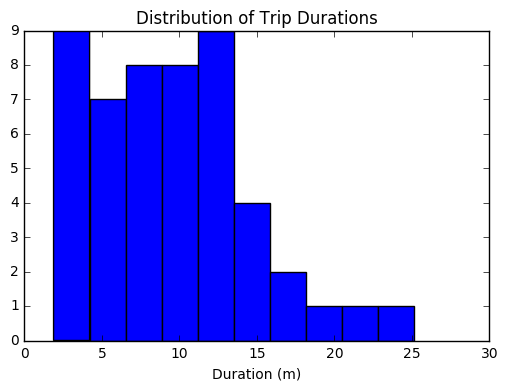

In [14]:
# load library
import matplotlib.pyplot as plt

# this is a 'magic word' that allows for plots to be displayed
# inline with the notebook. If you want to know more, see:
# http://ipython.readthedocs.io/en/stable/interactive/magics.html
%matplotlib inline 

# example histogram, data taken from bay area sample
data = [ 7.65,  8.92,  7.42,  5.50, 16.17,  4.20,  8.98,  9.62, 11.48, 14.33,
        19.02, 21.53,  3.90,  7.97,  2.62,  2.67,  3.08, 14.40, 12.90,  7.83,
        25.12,  8.30,  4.93, 12.43, 10.60,  6.17, 10.88,  4.78, 15.15,  3.53,
         9.43, 13.32, 11.72,  9.85,  5.22, 15.10,  3.95,  3.17,  8.78,  1.88,
         4.55, 12.68, 12.38,  9.78,  7.63,  6.45, 17.38, 11.90, 11.52,  8.63,]
plt.hist(data)
plt.title('Distribution of Trip Durations')
plt.xlabel('Duration (m)')
plt.show()

In the above cell, we collected fifty trip times in a list, and passed this list as the first argument to the `.hist()` function. This function performs the computations and creates plotting objects for generating a histogram, but the plot is actually not rendered until the `.show()` function is executed. The `.title()` and `.xlabel()` functions provide some labeling for plot context.

I will now use these functions to create a histogram of the trip times for the city you selected in question 4c. I didn't separate the Subscribers and Customers, just collect all of the trip times and plot them.

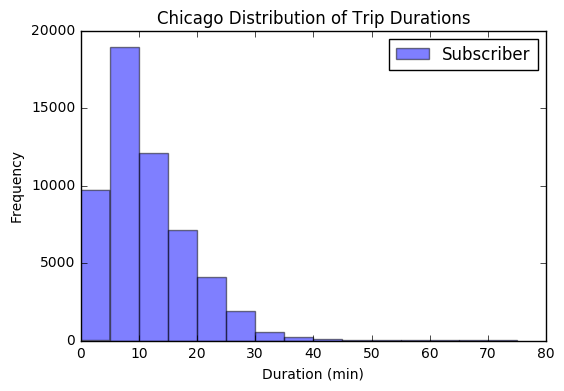

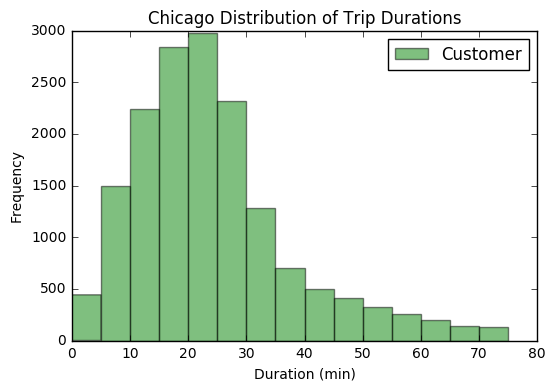

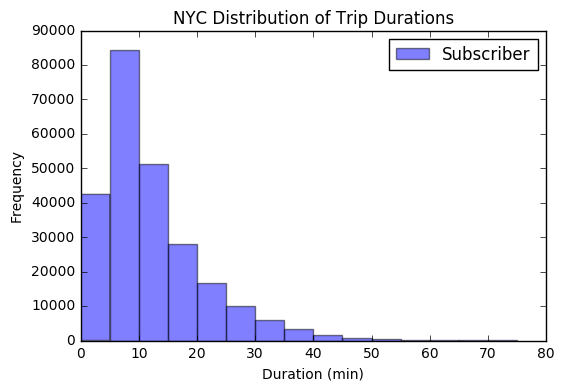

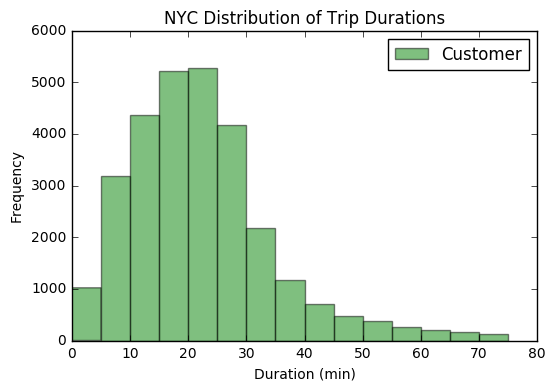

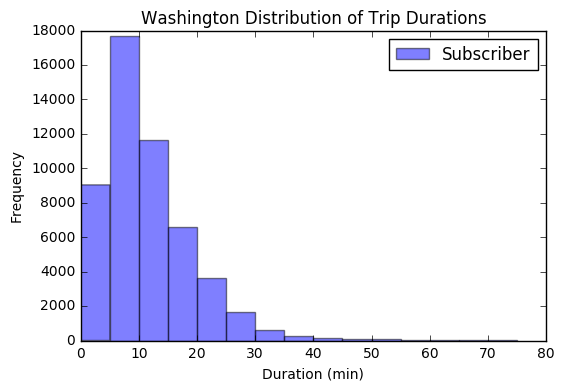

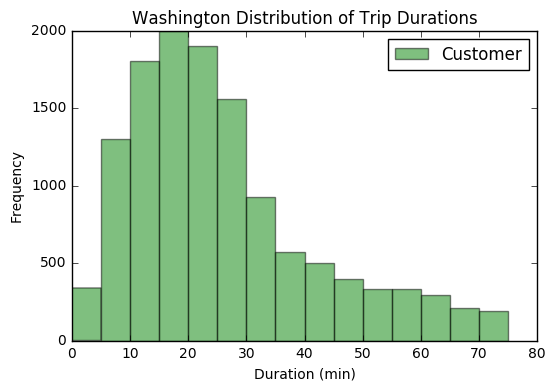

In [15]:
## Use this and additional cells to collect all of the trip times as a list ##
## and then use pyplot functions to generate a histogram of trip times.     ##

city_summary = {'Washington':'./data/Washington-2016-Summary.csv', 
                 'Chicago':'./data/Chicago-2016-Summary.csv',
                 'NYC':'./data/NYC-2016-Summary.csv'}


def collect_trip_time(filename):
    """
    This function reads in a file with city bike data and returns a set of only the 
    """
    
    sub_dur_data = []
    cust_dur_data = []
    
    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
                
        # Take all data in the 'duration' time column convert to a float type
        # Append them to either Subscriber and Customer lists 
        
        for row in reader:
            
            if row['user_type'] == 'Subscriber':
                sub_dur_data.append(float(row['duration']))
                
            elif row['user_type'] == 'Customer':
                cust_dur_data.append(float(row['duration']))

                    
    return sub_dur_data, cust_dur_data 

for city, city_summary in cities_summary.items():
    
    sub_times, cust_times = collect_trip_time(city_summary)

    plt.hist(sub_times, bins=15, range=(0,75), label='Subscriber', alpha=0.5)
    plt.title('{} Distribution of Trip Durations'.format(city))
    plt.xlabel('Duration (min)')
    plt.ylabel('Frequency')
    plt.legend(loc='upper right')
    plt.show()


    plt.hist(cust_times, bins=15, range=(0,75), label='Customer', alpha=0.5, color='green')
    plt.title('{} Distribution of Trip Durations'.format(city))
    plt.xlabel('Duration (min)')
    plt.ylabel('Frequency')
    plt.legend(loc='upper right')
    plt.show()

If you followed the use of the `.hist()` and `.show()` functions exactly like in the example above, you're probably notice the plot consists of one extremely tall bar on the left, maybe a very short second bar, and a whole lot of empty space in the center and right. Looking at the duration values on the x-axis, this suggests that there are some highly infrequent outliers in the data. Instead of reprocessing the data, I will use additional parameters with the `.hist()` function to limit the range of data that is plotted. Documentation for the function can be found [[here]](https://matplotlib.org/devdocs/api/_as_gen/matplotlib.pyplot.hist.html#matplotlib.pyplot.hist).

**Question 5**: Use the parameters of the `.hist()` function to plot the distribution of trip times for the Subscribers in your selected city. Do the same thing for only the Customers. Add limits to the plots so that only trips of duration less than 75 minutes are plotted. As a bonus, set the plots up so that bars are in five-minute wide intervals. For each group, where is the peak of each distribution? How would you describe the shape of each distribution?

**Answer**: see cell below for my response to Question 5.

## Use this and additional cells to answer Question 5. ##

#Do the same thing for only the Customers. - Ploted!
#Add limits to the plots so that only trips of duration less than 75 minutes are plotted. - Done!
#Bonus, set the plots up so that bars are in five-minute wide intervals. - Done!

5a) For each group, where is the peak of each distribution? 
- In order to get a better accuracy to answer this question I increased the BINs to 150 which provided smoother peaks in intervals of 30 seconds (75 minutes divided 150 bins). These are my findings:

    - Subscriber plot peak centered around 7-8 mins part of the distribution
    - Customer plot peak centered at 17-22 mins part of the distribution

5b) How would you describe the shape of each distribution?
- All plots are bell-shaped distributions
- The spread of the distribution is 0 to 75 minutes
- Shape of the distributions are:
    - non-symmetric
    - single peaks with RIGHT or POSITIVE skew (ie. towards smaller duration intervals)
    - unimodal thin tall squeezed bell-shaped peaks
    - non-uniformity
    
- The distribution shape has no gaps or outliers within the range observed (ie. 0-75 mins)
    - Obviously, this would change if to plotted the full values of the x-axis.
     

<a id='eda_continued'></a>
## Performing Your Own Analysis

So far, we've performed an initial exploration into the data available. I have compared the relative volume of trips made between three U.S. cities and the ratio of trips made by Subscribers and Customers. For one of these cities, I have investigated differences between Subscribers and Customers in terms of how long a typical trip lasts. I will answer the following questions:

- How does ridership differ by month or season? Which month / season has the highest ridership? Does the ratio of Subscriber trips to Customer trips change depending on the month or season?
- Is the pattern of ridership different on the weekends versus weekdays? On what days are Subscribers most likely to use the system? What about Customers? Does the average duration of rides change depending on the day of the week?
- During what time of day is the system used the most? Is there a difference in usage patterns for Subscribers and Customers?

As part of my investigation, I will create some visualizations. 

**Question 6**: What other questions can I answer by the data available? I document the questions I will explore below. My investigation will involve at least two variables and will compare at least two groups.

Using this and additional cells to continue to exploration of the dataset and document my findings

These are the extracts sample questions from above:

- How does ridership differ by month or season? 
- Which month / season has the highest ridership? 
- Does the ratio of Subscriber trips to Customer trips change depending on the month or season?
- Is the pattern of ridership different on the weekends versus weekdays? 
- What about Customers? Does the average duration of rides change depending on the day of the week?
- During what time of day is the system used the most? 
- Is there a difference in usage patterns for Subscribers and Customers?


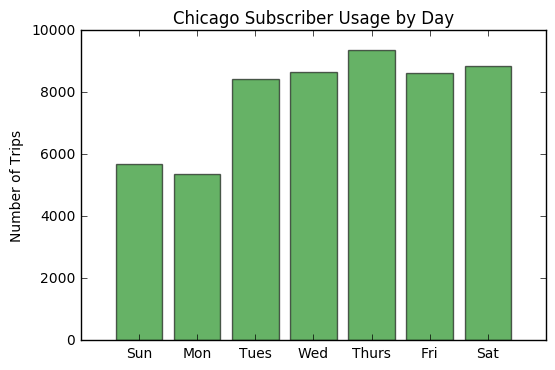

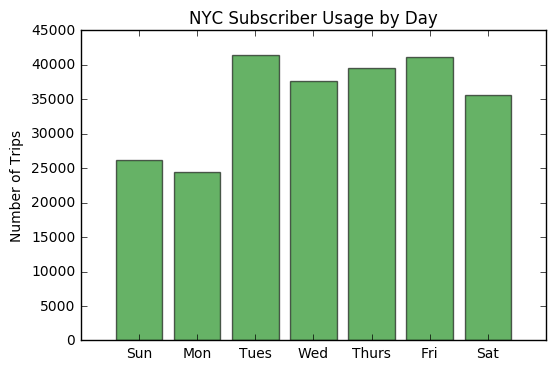

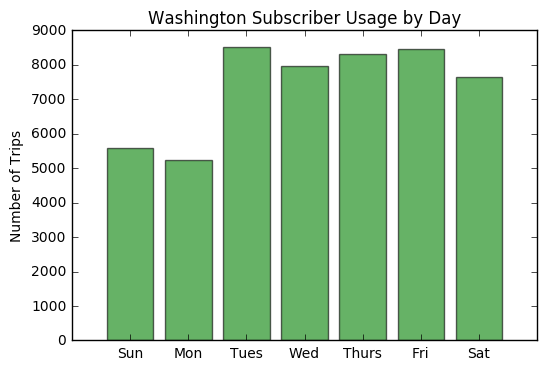

In [44]:
#6) On what days are Subscribers most likely NOT to use the system? 

#Will import the numpy package instead to get library to make a bar chart
#source:   https://pythonspot.com/matplotlib-bar-chart/

import numpy as np    

city_summary = {'Washington':'./data/Washington-2016-Summary.csv', 
                 'Chicago':'./data/Chicago-2016-Summary.csv',
                 'NYC':'./data/NYC-2016-Summary.csv'}

weekday_list = ['Sun', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat']
frequency_list = []

##########################################################
def collect_sub_days(filename):
    """
    This function reads in a file with city bike data and returns a set of occurances by weekday for subscribers
    """
    weekday_dict = {'Sunday': 0, 'Monday': 0, 'Tuesday': 0, 'Wednesday': 0, 'Thursday': 0, 'Friday': 0, 'Saturday': 0}
    frequency = []
    
    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
                
        # ATake all data in the 'duration' time column convert to a float type
        # Append them to either Subscriber and Customer lists 
        
        for row in reader:
            
            if row['user_type'] == 'Subscriber':
                day_of_week = row['day_of_week']
                weekday_dict[day_of_week] += 1
                
    for day in weekday_dict:
            frequency.append(weekday_dict[day]) 
    
    return frequency

##########################################################


for city, city_summary in cities_summary.items():
    
    frequency_list = collect_sub_days(city_summary)
    
    # Now time to plot a bar graph using the Numpy(np) library   
 
    y_pos = np.arange(len(weekday_list))    
    plt.bar(y_pos, frequency_list, align='center', color='green', alpha=0.6)
    plt.xticks(y_pos, weekday_list)
    plt.ylabel('Number of Trips')
    plt.title('{} Subscriber Usage by Day'.format(city))
    plt.show()

6) On what days are Subscribers most likely not to use the system? 

**Answer**: 
-> Based on the bar charts, it seems like the Subscribers is dramatically reduced at the beginning of the weekend, ie. on Sunday and Monday. This result was illustrated in not one but all THREE cities (NYC, Chicago, and Washington) as seen in above bar charts.

<a id='conclusions'></a>
## Conclusions

This is only a sampling of the data analysis process I used on this dataset: from generating questions, wrangling the data, and to exploring the data. Normally, at this point in the data analysis process, I might want to draw conclusions about the data by performing a statistical test or fitting the data to a model for making predictions. There are also a lot of potential analyses that could be performed on the data which are not possible with only the data provided. For example, detailed location data has not been investigated. Where are the most commonly used docks? What are the most common routes? As another example, weather has potential to have a large impact on daily ridership. How much is ridership impacted when there is rain or snow? Are subscribers or customers affected more by changes in weather?

**Question 7**: Putting the bike share data aside, think of a topic or field of interest where you would like to be able to apply the techniques of data science. What would you like to be able to learn from your chosen subject?

**Answer**: Able to analyze health data from studies and see if there are hidden patterns that prevent cancer.


Resources used to assist with coding in this assignment:

https://pythonspot.com/matplotlib-bar-chart/
https://matplotlib.org/devdocs/api/_as_gen/matplotlib.pyplot.hist.html#matplotlib.pyplot.hist
https://stackoverflow.com/questions/29530355/plotting-multiple-histograms-in-grid
https://www.tutorialspoint.com/python3/number_round.htm
https://www.youtube.com/watch?v=i_YIVTU36bE
https://en.wikipedia.org/wiki/Skewness#Sample_skewness
http://stattrek.com/statistics/charts/data-patterns.aspx?Tutorial=AP
